# Final Project: Impact of the Corona Virus on the Loan Industry

By Carter Pace, Spencer Siegel, Austin Cobb, Sarah Parker, Cecilia Zeng, Varun Srivstava

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_auc_score, roc_curve

## Gathering Data

In [ ]:
df_accepted = pd.read_csv("accepted_2007_to_2018Q4.csv")

In [ ]:
print(df_accepted.info())

In [ ]:
df_accepted.shape

In [ ]:
df_accepted.loan_status.value_counts()

In [ ]:
df = df_accepted[df_accepted['loan_status'].isin(['Fully Paid', 'Charged Off', 'Default'])]

## Cleaning Data

In [ ]:
df['year'] = df['issue_d'].str.strip().str[-4:]

In [ ]:
df.year.value_counts()

In [ ]:
df = df[df['year'].isin(['2014', '2015', '2016', '2017', '2018'])]

In [ ]:
df.shape

In [ ]:
df.columns

In [ ]:
total_num = df.isnull().sum().sort_values(ascending=False)

In [ ]:
perc = df.isnull().sum()/df.isnull().count() *100
perc1 = (round(perc,2).sort_values(ascending=False))

# Creating a data frame:
df_miss = pd.concat([total_num, perc1], axis =1 , keys =["Total Missing Values", "Percentage %"]).sort_values(by ="Percentage %", ascending = False)

In [ ]:
top_mis = df_miss[df_miss["Percentage %"]<10]
top_mis.reset_index(inplace=True)
vals = list(top_mis['index'])

In [ ]:
df = df[vals]

In [ ]:
df.shape

Next, our team analyzed the correlations between variables. In order to do this, we had to drop the remainder of the missing values because correlation cannot be run on missing values. Variables that are highly correlated or highly inversely correlated have a strong relationship and can give the same information and can skew the results. Specifically, we are only looking at correlation between numerical variables. Correlation between categorical variables does not give any useful information.

Source for correlation code: https://www.kaggle.com/pavlofesenko/minimizing-risks-for-loan-investments

In [ ]:
num_feat = df.select_dtypes('number').columns.values
df[num_feat].nunique().sort_values()

In [ ]:
from itertools import combinations
from scipy.stats import pearsonr

df2 = df.dropna()
num_feat = df2.select_dtypes('number').columns.values
comb_num_feat = np.array(list(combinations(num_feat, 2)))
corr_num_feat = np.array([])
for comb in comb_num_feat:
    corr = pearsonr(df2[comb[0]], df2[comb[1]])[0]
    corr_num_feat = np.append(corr_num_feat, corr)

In [ ]:
corr_num_feat

In [ ]:
high_corr_num = comb_num_feat[np.abs(corr_num_feat) >= 0.8]
high_corr_num

In [ ]:
#keep loan_amnt
arr = np.unique(high_corr_num[:, 0])
indexPos = np.where(arr=='loan_amnt')
arr = np.delete(arr, indexPos)

df3 = df.drop(arr, axis=1, errors='ignore')
df3.shape

In [ ]:
df3.head()

In [ ]:
df3['loan_status'].value_counts()

In [ ]:
df4 = df3.select_dtypes(include='object')

In [ ]:
df4.info()

In [ ]:
drop_col = ['emp_title', 
            'title', 
            'last_pymnt_d', 
            'pymnt_plan', 
            'url', 
            'id', 
            'hardship_flag', 
            'grade', 
            'earliest_cr_line', 
            'year', 
            'last_credit_pull_d', 
            'zip_code',
            
            ##numerical variables
            #'last_fico_range_low',
            'last_pymnt_amnt',
            ]

In [ ]:
df3.last_pymnt_d
from datetime import datetime
from dateutil import relativedelta
df3['num_pmnts'] = round(((pd.to_datetime(df3.last_pymnt_d)-pd.to_datetime(df3.issue_d))/np.timedelta64(1, 'M'))-1)

In [ ]:
df3 = df3.drop(drop_col, axis=1)

In [ ]:
df4 = df3.select_dtypes(include='object')
categorical_features = list(df4.columns)

In [ ]:
for col in categorical_features:
    df3[col] = df3[col].astype('category')

In [ ]:
df3['policy_code'] = df3['policy_code'].astype('category')

In [ ]:
df3.info()

## Finetuning the Model

In [ ]:
libor = pd.read_csv('libor.csv') 
libor.head()

In [ ]:
df3['issue_d'] = df3['issue_d'].astype('object')
df123 = pd.merge(df3, libor, left_on='issue_d', right_on='month')
df123.head()

In [ ]:
df123 = df123.drop('month', axis=1)
df123 = df123.dropna()
df123.shape

In [ ]:
def get_installment_and_terms(row):
    return int(row['term'][:3])*row['installment']

def get_returns(row):
    if row['loan_status']=='Fully Paid':
        return round(row['loan_amnt']*((1+((row['int_rate']/100)/12))**(int(row['term'][:3])/2)),2)
    else:
        return round(row['loan_amnt']*((1+((row['int_rate']/100)/12))**(int(row['num_pmnts'])/2)),2)-row['loan_amnt']

def get_annualized_returns(row):
    return row['returns']-row['loan_amnt']

In [ ]:
#create the return variables based on above definitions
df123['returns'] = df123.apply (lambda row: get_returns(row), axis=1)
df123['installments_and_terms'] = df123.apply (lambda row: get_installment_and_terms(row), axis=1)
df123['annualized_returns'] = df123.apply (lambda row: get_annualized_returns(row), axis=1)

In [ ]:
df123['loan_status']=np.where(df123.loan_status=='Default','Charged Off',df123.loan_status)
df123 = df123.drop('num_pmnts', axis=1)
df123.to_csv("Cleaned_Data2.csv")

## Data Adjustment

In [ ]:
df = pd.read_csv('Cleaned_Data2.csv')

In [ ]:
#change the 'object' categories to 'category'
df2 = df.select_dtypes(include='object')
categorical_features = list(df2.columns)
for col in categorical_features:
    df[col] = df[col].astype('category')

In [ ]:
#remove the former 'id' column
df = df.drop('Unnamed: 0', axis=1)

In [ ]:
df.info()

In [ ]:
df.loan_status.value_counts()

In [ ]:
numeric_features = df.select_dtypes(include=['int64', 'float64']).drop(['returns', 'installments_and_terms', 'annualized_returns'], axis=1).columns
categorical_features = df.select_dtypes(include=['category']).drop(['loan_status'], axis=1).columns

print(numeric_features)
print(categorical_features)

In [ ]:
df.isnull().sum()

In [ ]:
#total number of null values
df.isnull().sum().sum()

In [ ]:
# #this cell takes >10 minutes to run, so can't run this on full data sheet
# #impute numeric values
# imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
# imputer = imputer.fit(df[numeric_features.tolist()])
# df[numeric_features.tolist()] = imputer.transform(df[numeric_features.tolist()])
# #impute categorical values
# imputerCat = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
# df[categorical_features] = imputerCat.fit_transform(df[categorical_features.tolist()])
# print(df.isnull().sum())

In [ ]:
# Create a function we can simply call to generate all the metrics and graph we need
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    baseline = {}
    baseline['recall'] = recall_score(y_test, [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test, [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    results = {}
    results['recall'] = recall_score(y_test, predictions)
    results['precision'] = precision_score(y_test, predictions)
    results['roc'] = roc_auc_score(y_test, probs)
    train_results = {}
    train_results['recall'] = recall_score(y_train, train_predictions)
    train_results['precision'] = precision_score(y_train, train_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_probs)
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)
    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

In [ ]:
samples = list()
allRows = df.index.values
for i in range(5):
    choices = np.random.choice(allRows, 50000, replace=False)
    samples.append(choices)
    allRows = np.setdiff1d(allRows, choices)

## Sample of 50,000

In [ ]:
data = df.copy().iloc[samples[0],:]
data.isnull().sum()

In [ ]:
#impute numeric values
#imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
#imputer = imputer.fit(data[numeric_features.tolist()])
#data[numeric_features.tolist()] = imputer.transform(data[numeric_features.tolist()])

#impute categorical values
#imputerCat = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
#data[categorical_features] = imputerCat.fit_transform(data[categorical_features.tolist()])

#print(data.isnull().sum())

## AdaBoost Classifier (for Loan Default)

In [ ]:
xVar = data.columns
xVar = xVar.drop(['loan_status', 'returns', 'installments_and_terms', 'annualized_returns'])

X = data.loc[:, xVar]
y = data.loan_status

#used to get dummy variables
X = pd.get_dummies(X)
repmap={"Fully Paid": 1, "Charged Off": 0}
y.replace(repmap, inplace=True)

In [ ]:
#train/test split cell
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = 1)

#remove random state eventually

In [ ]:
dt = DecisionTreeClassifier(
    max_depth=1 
    , criterion='gini' 
    , min_samples_leaf = 10 
    , splitter = 'random'
#     , random_state=42
)

adb_clf = AdaBoostClassifier(base_estimator=dt, n_estimators=25)
adb_clf.fit(X_train, y_train)

# Predict the test data
y_pred = adb_clf.predict(X_test)

In [ ]:
#accuracy score
print(accuracy_score(y_test, y_pred))

#confusion matrix
con_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix_df = pd.DataFrame(con_matrix, ('Decline', 'Approve'), ('Decline', 'Approve'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d", cmap="Blues")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)

#precision, recall and f1-score
print(classification_report(y_test, y_pred))

In [ ]:
# Evaluating model performance unsing AUC
train_probs = adb_clf.predict_proba(X_train)[:, 1]
probs = adb_clf.predict_proba(X_test)[:, 1]
train_predictions = adb_clf.predict(X_train)
predictions = adb_clf.predict(X_test)
ada_AUC=roc_auc_score(y_test, probs)

evaluate_model(predictions, probs, train_predictions, train_probs)

## Stochastic Gradient Boosting (for Annualized Returns)

In [ ]:
xVar = data.columns
xVar = xVar.drop(['loan_status', 'returns', 'installments_and_terms', 'annualized_returns'])

X = data.loc[:, xVar]
y = data.annualized_returns

#used to get dummy variables
X = pd.get_dummies(X)

In [ ]:
#train/test split cell
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

#remove random state eventually

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

sgbt = GradientBoostingRegressor(
    max_depth=1
    , subsample=0.33
    , max_features=0.67
    , n_estimators=100
#     , random_state=42
)
sgbt.fit(X_train, y_train)

# Predict the test set labels
y_pred = sgbt.predict(X_test)

# Evaluate test set RMSE 'rmse_test'
rmse_test = MSE(y_test, y_pred)**(1/2)

# Print 'rmse_test'
print('Test set RMSE: {:.2f}'.format(rmse_test))

In [ ]:
limit = 100 #max = 10000

x = np.arange(len(y_test))[:limit]
# y_test.values.tolist()

plt.scatter(x, y_test[:limit])
plt.scatter(x, y_pred[:limit])

fig = plt.gcf()
fig.set_size_inches(16,5)

plt.show()

In [ ]:
#showing the difference plotted instead of each variable
limit = 100 #max = 10000

x = np.arange(len(y_test))[:limit]
y_plot = y_test-y_pred
# print(np.mean(y_plot))

plt.scatter(x, y_plot[:limit])
plt.hlines(0, xmin=0, xmax=limit)

plt.xlim(0,limit)

fig = plt.gcf()
fig.set_size_inches(16,5)

plt.show()

## Modeling with Percent Return

In [ ]:
data = df.copy().iloc[samples[1],:]
data['percent_return'] = data['annualized_returns']/data['loan_amnt']
xVar = data.columns
xVar = xVar.drop(['loan_status', 'returns', 'installments_and_terms', 'annualized_returns','percent_return'])
X = data.loc[:, xVar]
y = data.percent_return

#used to get dummy variables
X = pd.get_dummies(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

sgbt = GradientBoostingRegressor(
    max_depth=1
    , subsample=0.33
    , max_features=0.67
    , n_estimators=200
#     , random_state=42
)
sgbt.fit(X_train, y_train)

# Predict the test set labels
y_pred = sgbt.predict(X_test)

# Evaluate test set RMSE 'rmse_test'
rmse_test = MSE(y_test, y_pred)**(1/2)

# Print 'rmse_test'
print('Test set RMSE: {:.2f}'.format(rmse_test))

In [ ]:

from sklearn import metrics, model_selection
def evaluate(y_test, y_pred):
    # this block of code returns all the metrics we are interested in 
    mse = metrics.mean_squared_error(y_test, y_pred)
    msa = metrics.mean_absolute_error(y_test, y_pred)
    r2 = metrics.r2_score(y_test, y_pred)

    print("Mean squared error: ", mse)
    print("Mean absolute error: ", msa)
    print("R^2 : ", r2)
    
    # this creates a chart plotting predicted and actual 
    plt.figure(figsize=(12,6))
    plt.scatter(y_test, y_pred)
    plt.xlabel("Percent Return: $y_i$")
    plt.ylabel("Predicted percent return: $\hat{y}_i$")
    plt.title("Percent Return vs Predicted Percent Return: $y_i$ vs $\hat{y}_i$")

In [ ]:
evaluate(y_test,y_pred)

In [ ]:
params = {'max_depth':[1], 'subsample':[0.33], 'max_features':[0.5,0.67], 'n_estimators':[100,200]}

# we then create a grid search object with our chosen model and paramters. 
grid = model_selection.GridSearchCV(sgbt, params, cv=10, iid=False)

# we fit our model to the data as before
grid.fit(X_train, y_train)

# one output of the grid search function is that we can get the best_estimator - the model and parameters that scored best on the training data - 
#  and save it as a new a model
best_model = grid.best_estimator_

# and use it to predict and evaluate as before
y_pred = best_model.predict(X_test)

evaluate(y_test, y_pred)

print(grid.best_params_)
print(grid.best_score_)

In [ ]:
import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]
X_test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test.columns.values]

In [ ]:
#!pip install xgboost
import xgboost as xgb
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.01,
                max_depth = 10, colsample_bytree=0.5,min_child_weight=3, gamma = 0.2, n_estimators = 500)
xg_reg.fit(X_train, y_train)

# Predict the test set labels
y_pred = xg_reg.predict(X_test)

# Evaluate test set RMSE 'rmse_test'
rmse_test = MSE(y_test, y_pred)**(1/2)

# Print 'rmse_test'
print('Test set RMSE: {:.2f}'.format(rmse_test))

In [ ]:
evaluate(y_test,y_pred)

In [ ]:
params = {"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }

# we then create a grid search object with our chosen model and paramters. 
grid = model_selection.GridSearchCV(sgbt, params, cv=10, iid=False)

# we fit our model to the data as before
grid.fit(X_train, y_train)

# one output of the grid search function is that we can get the best_estimator - the model and parameters that scored best on the training data - 
#  and save it as a new a model
best_model = grid.best_estimator_

# and use it to predict and evaluate as before
y_pred = best_model.predict(X_test)

evaluate(y_test, y_pred)

print(grid.best_params_)
print(grid.best_score_)

In [ ]:
xgb.plot_importance(xg_reg,max_num_features=10)
plt.show()

## Model to Predict Percent Return on Fully Paid Loans

In [ ]:
data = df[df['loan_status']=='Fully Paid'].sample(50000)
data['percent_return'] = data['annualized_returns']/data['loan_amnt']
xVar = data.columns
xVar = xVar.drop(['loan_status', 'returns', 'installments_and_terms', 'annualized_returns','percent_return'])
X = data.loc[:, xVar]
y = data.percent_return

#used to get dummy variables
X = pd.get_dummies(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

In [ ]:
import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]
X_test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test.columns.values]

In [ ]:
import xgboost as xgb
xg_reg2 = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.01,
                max_depth = 10, colsample_bytree=0.5,min_child_weight=3, gamma = 0.2, n_estimators = 500)
xg_reg2.fit(X_train, y_train)

# Predict the test set labels
y_pred = xg_reg2.predict(X_test)

# Evaluate test set RMSE 'rmse_test'
rmse_test = MSE(y_test, y_pred)**(1/2)

# Print 'rmse_test'
print('Test set RMSE: {:.2f}'.format(rmse_test))

In [ ]:
evaluate(y_test,y_pred)

In [ ]:
xgb.plot_importance(xg_reg2,max_num_features=10)
plt.show()

## Model to Predict Percent Return on Defaulted Loans

In [ ]:
data = df[df['loan_status']=='Charged Off'].sample(50000)
data['percent_return'] = data['annualized_returns']/data['loan_amnt']
xVar = data.columns
xVar = xVar.drop(['loan_status', 'returns', 'installments_and_terms', 'annualized_returns','percent_return'])
X = data.loc[:, xVar]
y = data.percent_return

#used to get dummy variables
X = pd.get_dummies(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

In [ ]:
import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]
X_test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test.columns.values]

In [ ]:
import xgboost as xgb
xg_reg3 = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.01,
                max_depth = 10, colsample_bytree=0.5,min_child_weight=3, gamma = 0.2, n_estimators = 500)
xg_reg3.fit(X_train, y_train)

# Predict the test set labels
y_pred = xg_reg3.predict(X_test)

# Evaluate test set RMSE 'rmse_test'
rmse_test = MSE(y_test, y_pred)**(1/2)

# Print 'rmse_test'
print('Test set RMSE: {:.2f}'.format(rmse_test))

In [ ]:
evaluate(y_test,y_pred)

In [ ]:
xgb.plot_importance(xg_reg3,max_num_features=10)
plt.show()

## Comparison of 3 Strategies

In [ ]:
data = pd.concat([df.copy().iloc[samples[2],:],df.copy().iloc[samples[3],:],df.copy().iloc[samples[4],:],])
data['percent_return'] = data['annualized_returns']/data['loan_amnt']
xVar = data.columns
xVar = xVar.drop(['loan_status', 'returns', 'installments_and_terms', 'annualized_returns','percent_return'])
X = data.loc[:, xVar]
X = pd.get_dummies(X)
y = data.percent_return

## Method 1: Using the Default Model (Result: ~15% Return)

In [ ]:
prediction1 = pd.DataFrame(adb_clf.predict_proba(X),columns=['Default','Fully Paid'])
prediction1['percent_return'] = y.values

# These are the loans we pick
prediction1.nlargest(1000,'Fully Paid')

In [ ]:
# Percent return by this strategy
np.mean(prediction1.nlargest(1000,'Fully Paid').percent_return)

In [ ]:
plt.hist(prediction1.nlargest(1000,'Fully Paid')['percent_return'], bins=100)
plt.xlabel('Annual Return rate')
plt.ylabel('Loans per bin')
plt.title('Default Model Profolio Return distribution')

## Method 2: Using the Return Model (Result: ~95% Return)

In [ ]:
import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X.columns.values]

In [ ]:
prediction2 = pd.DataFrame(xg_reg.predict(X),columns=['Predicted Return'])
prediction2['Actual Return'] = y.values
# These are the loans we pick
prediction2.nlargest(1000,'Predicted Return')

In [ ]:
np.mean(prediction2.nlargest(1000,'Predicted Return')['Actual Return'])

In [ ]:
plt.hist(prediction2.nlargest(1000,'Predicted Return')['Actual Return'], bins=100)
plt.xlabel('Annual Return rate')
plt.ylabel('Loans per bin')
plt.title('Return Model Profolio Return distribution')

## Method 3: Using the Combined Approach (Result: ~83% Return)

In [ ]:
prediction3 = pd.concat([pd.DataFrame(adb_clf.predict_proba(X),columns=['Default','Fully Paid']),
           pd.DataFrame(xg_reg2.predict(X),columns=['Fully Paid Predicted Return']),
          pd.DataFrame(xg_reg3.predict(X),columns=['Defaulted Predicted Return'])],axis=1)

In [ ]:
prediction3['Expected Return']=prediction3['Default']*prediction3['Defaulted Predicted Return']+prediction3['Fully Paid']*prediction3['Fully Paid Predicted Return']

prediction3['Actual Return'] = y.values

In [ ]:
# These are the loans we pick
prediction3.nlargest(1000,'Expected Return')

In [ ]:
np.mean(prediction3.nlargest(1000,'Expected Return')['Actual Return'])

In [ ]:
plt.hist(prediction3.nlargest(1000,'Expected Return')['Actual Return'], bins=100)
plt.xlabel('Annual Return rate')
plt.ylabel('Loans per bin')
plt.title('Combination Model Profolio Return distribution')

In [ ]:
my_dict = {'Default': prediction1.nlargest(1000,'Fully Paid')['percent_return'], 'Return': prediction2.nlargest(1000,'Predicted Return')['Actual Return'], 'Combined':prediction3.nlargest(1000,'Expected Return')['Actual Return']}

fig, ax = plt.subplots()
bplot = ax.boxplot(my_dict.values())
ax.set_xticklabels(my_dict.keys())
ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)
ax.set_axisbelow(True)
ax.set_title('Comparison of Three Prediction Models')
ax.set_ylabel('Return Rate')

## Sentiment Analysis of Loan Industry: Pre & Post Corona Virus

In [1]:
!pip install twitterscraper

In [2]:
from twitterscraper import query_tweets
import pandas as pd
import numpy as np
import datetime
import time

INFO: {'User-Agent': 'Mozilla/5.0 (compatible, MSIE 11, Windows NT 6.3; Trident/7.0; rv:11.0) like Gecko'}


# Loan Industry

### 2019 Tweets

In [3]:
kw_list = ['"loan" OR "Loan"']
begin = datetime.date(2019, 2, 28)
end = datetime.date(2019, 4, 30)
limit = 3000
lang = 'en'
poolsize = 5

In [4]:
if __name__ == '__main__':
    start_time = time.time()
    tweets = query_tweets(query=" OR ".join(kw_list),
                         begindate=begin,
                         enddate = end,
                         limit = limit,
                         lang = lang,
                         poolsize = poolsize,
                         )
print(str(len(tweets)) + " tweets scraped in " + str(round(time.time() - start_time, 2)) + " seconds ")

INFO: queries: ['"loan" OR "Loan" since:2019-02-28 until:2019-03-12', '"loan" OR "Loan" since:2019-03-12 until:2019-03-24', '"loan" OR "Loan" since:2019-03-24 until:2019-04-05', '"loan" OR "Loan" since:2019-04-05 until:2019-04-17', '"loan" OR "Loan" since:2019-04-17 until:2019-04-30']
INFO: Querying "loan" OR "Loan" since:2019-03-24 until:2019-04-05
INFO: Querying "loan" OR "Loan" since:2019-03-12 until:2019-03-24
INFO: Querying "loan" OR "Loan" since:2019-02-28 until:2019-03-12
INFO: Querying "loan" OR "Loan" since:2019-04-05 until:2019-04-17
INFO: Querying "loan" OR "Loan" since:2019-04-17 until:2019-04-30
INFO: Scraping tweets from https://twitter.com/search?f=tweets&vertical=default&q="loan"%20OR%20"Loan"%20since%3A2019-03-24%20until%3A2019-04-05&l=en
INFO: Scraping tweets from https://twitter.com/search?f=tweets&vertical=default&q="loan"%20OR%20"Loan"%20since%3A2019-02-28%20until%3A2019-03-12&l=en
INFO: Scraping tweets from https://twitter.com/search?f=tweets&vertical=default&q="l

INFO: Using proxy 177.202.43.110:34257
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaGwLupsbnT1h4WgICnwdfd1NYeEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20since%3A2019-02-28%20until%3A2019-03-12&l=en
INFO: Using proxy 187.86.137.141:58918
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAgL_FhPb_hB8WgIC3oZmrgYUfEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20since%3A2019-04-05%20until%3A2019-04-17&l=en
INFO: Using proxy 187.86.137.141:58918
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAgKfB1p6M5h4WgICrobKijuYeEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%

INFO: Using proxy 203.142.58.69:38732
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaKgLDN7uT-hB8WgIC3oZmrgYUfEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20since%3A2019-04-05%20until%3A2019-04-17&l=en
INFO: Using proxy 203.142.58.69:38732
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAgKfdzoCK5h4WgICrobKijuYeEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20since%3A2019-03-12%20until%3A2019-03-24&l=en
INFO: Using proxy 109.238.222.5:58250
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaMwLW9rKPS1h4WgICnwdfd1NYeEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20s

INFO: Using proxy 113.53.91.12:53281
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaEwL2R27nD9R4WgoC_ieHhx_UeEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20since%3A2019-03-24%20until%3A2019-04-05&l=en
INFO: Using proxy 113.53.91.12:53281
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAwLb9_tvblR8WgoCh-d7W35UfEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20since%3A2019-04-17%20until%3A2019-04-30&l=en
INFO: Using proxy 113.53.91.12:53281
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAgLahif3Q1h4WgICnwdfd1NYeEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20sinc

INFO: Using proxy 62.4.60.50:53281
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAwLXN2e7B9R4WgoC_ieHhx_UeEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20since%3A2019-03-24%20until%3A2019-04-05&l=en
INFO: Using proxy 62.4.60.50:53281
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAgLX51O2G5h4WgICrobKijuYeEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20since%3A2019-03-12%20until%3A2019-03-24&l=en
INFO: Using proxy 62.4.60.50:53281
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAgLa1wbjalR8WgoCh-d7W35UfEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20since%3A20

INFO: Using proxy 107.190.148.202:50854
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaCgL3B_LT6hB8WgIC3oZmrgYUfEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20since%3A2019-04-05%20until%3A2019-04-17&l=en
INFO: Using proxy 107.190.148.202:50854
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaMwLbJn8jA9R4WgoC_ieHhx_UeEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20since%3A2019-03-24%20until%3A2019-04-05&l=en
INFO: Using proxy 107.190.148.202:50854
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaCwLa56dmE5h4WgICrobKijuYeEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loa

INFO: Using proxy 85.196.183.162:8080
INFO: Using proxy 85.196.183.162:8080
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaEgLWV17rN1h4WgICnwdfd1NYeEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20since%3A2019-02-28%20until%3A2019-03-12&l=en
INFO: Using proxy 69.65.65.178:34548
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaCwL3V1fL4hB8WgIC3oZmrgYUfEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20since%3A2019-04-05%20until%3A2019-04-17&l=en
INFO: Using proxy 69.65.65.178:34548
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAgKPtyZy_9R4WgoC_ieHhx_UeEjUAFQA

3076 tweets scraped in 57.27 seconds 


In [5]:
tweets2019_df = pd.DataFrame(columns = ['timestamp', 'username', 'user_id', 'tweet_id',
                                   'text', 'likes', 'replies', 'retweets', 'tweet_url', 'parent_tweet_id'])

In [6]:
for tweet in tweets:
    tweets2019_df = tweets2019_df.append({
        'timestamp': tweet.timestamp,
        'username': tweet.username,
        'screen_name': tweet.screen_name,
        'user_id': tweet.user_id,
        'tweet_id': tweet.tweet_id,
        'text': tweet.text,
        'likes': tweet.likes,
        'replies': tweet.replies,
        'retweets': tweet.retweets,
        'tweet_url': tweet.tweet_url,
        'parent_tweet_id': tweet.parent_tweet_id}, ignore_index=True)
    
import gc
del tweets
gc.collect()

0

In [7]:
tweets2019_df.tail(25)

,timestamp,username,user_id,tweet_id,text,likes,replies,retweets,tweet_url,parent_tweet_id,screen_name
3051,2019-04-16 22:38:02,Ant,949308226885087232,1118282429280718860,They just got approved for a $77 million loan ...,0,0,0,/TellemTwan/status/1118282429280718860,1118216817917345792,TellemTwan
3052,2019-04-16 22:38:00,the keri diaries,1636121923,1118282422238445568,How do I ask family for money without sounding...,1,0,0,/therealkeri/status/1118282422238445568,,therealkeri
3053,2019-04-16 22:37:56,Davido Da-Vinci,193652791,1118282403360006145,I need a bank that will do two things for me: ...,0,0,0,/Datchowski/status/1118282403360006145,,Datchowski
3054,2019-04-16 22:37:50,"Neal Brown, REALTOR",1002210571289333762,1118282377867026434,If you are a veteran I thank you for your serv...,0,0,0,/NBrownRealtor/status/1118282377867026434,,NBrownRealtor
3055,2019-04-16 22:37:42,"Neal Brown, REALTOR",1002210571289333762,1118282345734340608,Thanks for your service veterans and be sure t...,0,0,0,/NBrownRealtor/status/1118282345734340608,,NBrownRealtor
3056,2019-04-16 22:37:39,Alberta411,2792624479,1118282332027277312,Need some advice about getting a loan http://r...,1,0,0,/Alberta411/status/1118282332027277312,,Alberta411
3057,2019-04-16 22:37:26,Robert M Campbell Jr,2911481020,1118282276410933248,I believe it was in Peter that Jesus said ‘I’m...,0,0,0,/rmfcjr/status/1118282276410933248,1118187664786767872,rmfcjr
3058,2019-04-16 22:37:21,taxman,456306667,1118282259478585345,How does wall street benefit from government l...,0,0,0,/taxman1980/status/1118282259478585345,1118249929275842561,taxman1980
3059,2019-04-16 22:37:10,io 🎈,99687065,1118282210308759553,WILL GIVE SOME1 MY WHOLE STUDENT LOAN 2 FINISH...,3,1,0,/ionaskye_/status/1118282210308759553,,ionaskye_
3060,2019-04-16 22:37:09,John Wojtasiak,28570244,1118282206907129857,Thinking of exaggerating on that loan applicat...,0,0,0,/JohnWojtasiak/status/1118282206907129857,,JohnWojtasiak


In [8]:
tweets2019_df.text.to_csv("2019_texts.csv", index=False, header=False, sep='\t', encoding='utf-16')

In [9]:
tweets2019_df.to_csv("2019TwitterScraper.csv", index = False)

### 2020 Tweets

In [10]:
from twitterscraper import query_tweets
kw_list = ['"loan" OR "Loan"']
begin = datetime.date(2020, 2, 27)
end = datetime.date(2020, 4, 30)
limit = 3000
lang = 'en'
poolsize = 5

if __name__ == '__main__':
    start_time = time.time()
    tweets = query_tweets(query=" OR ".join(kw_list),
                         begindate = begin,
                         enddate = end,
                         limit = limit,
                         lang = lang,
                         poolsize = poolsize,
                         )
display(str(len(tweets)) + " tweets scraped in " + str(round(time.time() - start_time, 2)) + " seconds")

tweets2020_df = pd.DataFrame(columns = ['timestamp', 'username', 'screen_name', 'user_id', 'tweet_id',
                                    'text', 'likes', 'replies', 'retweets', 'tweets_url', 'parent_tweet_id'])

for tweet in tweets: 
    tweets2020_df = tweets2020_df.append({
        'timestamp': tweet.timestamp,
        'username': tweet.username,
        'screen_name': tweet.screen_name,
        'user_id': tweet.user_id,
        'tweet_id': tweet.tweet_id,
        'text': tweet.text,
        'likes': tweet.likes,
        'replies': tweet.replies,
        'retweets': tweet.retweets, 
        'parent_tweet_id': tweet.parent_tweet_id}, ignore_index=True)
    
import gc
del tweets
gc.collect()

INFO: queries: ['"loan" OR "Loan" since:2020-02-27 until:2020-03-10', '"loan" OR "Loan" since:2020-03-10 until:2020-03-23', '"loan" OR "Loan" since:2020-03-23 until:2020-04-04', '"loan" OR "Loan" since:2020-04-04 until:2020-04-17', '"loan" OR "Loan" since:2020-04-17 until:2020-04-30']
INFO: Querying "loan" OR "Loan" since:2020-02-27 until:2020-03-10
INFO: Querying "loan" OR "Loan" since:2020-03-10 until:2020-03-23
INFO: Querying "loan" OR "Loan" since:2020-03-23 until:2020-04-04
INFO: Querying "loan" OR "Loan" since:2020-04-04 until:2020-04-17
INFO: Scraping tweets from https://twitter.com/search?f=tweets&vertical=default&q="loan"%20OR%20"Loan"%20since%3A2020-02-27%20until%3A2020-03-10&l=en
INFO: Scraping tweets from https://twitter.com/search?f=tweets&vertical=default&q="loan"%20OR%20"Loan"%20since%3A2020-04-04%20until%3A2020-04-17&l=en
INFO: Querying "loan" OR "Loan" since:2020-04-17 until:2020-04-30
INFO: Scraping tweets from https://twitter.com/search?f=tweets&vertical=default&q="l

INFO: Using proxy 177.202.43.110:34257
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaEgLzZ6o2EvCIWhICwqdS1hLwiEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20since%3A2020-03-10%20until%3A2020-03-23&l=en
INFO: Using proxy 187.86.137.141:58918
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaCgKeVtLSlqyIWgoC1pcGKpqsiEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20since%3A2020-02-27%20until%3A2020-03-10&l=en
INFO: Using proxy 187.86.137.141:58918
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaGwLzV6s-9yyIWgIC1ran6vcsiEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%

INFO: Using proxy 203.142.58.69:38732
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaOwL697en57CIWgsC13bjO-uwiEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20since%3A2020-04-17%20until%3A2020-04-30&l=en
INFO: Using proxy 203.142.58.69:38732
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaKwLTlh8GkqyIWgoC1pcGKpqsiEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20since%3A2020-02-27%20until%3A2020-03-10&l=en
INFO: Using proxy 109.238.222.5:58250
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaCwLztn9qDvCIWhICwqdS1hLwiEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20s

INFO: Using proxy 113.53.91.12:53281
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaCwLSxuue8yyIWgIC1ran6vcsiEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20since%3A2020-03-23%20until%3A2020-04-04&l=en
INFO: Using proxy 113.53.91.12:53281
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAwKbZvKn57CIWgsC13bjO-uwiEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20since%3A2020-04-17%20until%3A2020-04-30&l=en
INFO: Using proxy 113.53.91.12:53281
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAgLupjMejqyIWgoC1pcGKpqsiEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20sinc

INFO: Using proxy 62.4.60.50:53281
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAwL2pjJaDvCIWhICwqdS1hLwiEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20since%3A2020-03-10%20until%3A2020-03-23&l=en
INFO: Using proxy 62.4.60.50:53281
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaGgLWdmLe8yyIWgIC1ran6vcsiEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20since%3A2020-03-23%20until%3A2020-04-04&l=en
INFO: Using proxy 62.4.60.50:53281
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaGwLTtq-r47CIWgsC13bjO-uwiEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20since%3A20

INFO: Using proxy 188.163.170.130:41209
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaCgLv1woi8yyIWgIC1ran6vcsiEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20since%3A2020-03-23%20until%3A2020-04-04&l=en
INFO: Using proxy 107.190.148.202:50854
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaagLuxvOeCvCIWhICwqdS1hLwiEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20since%3A2020-03-10%20until%3A2020-03-23&l=en
INFO: Using proxy 107.190.148.202:50854
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAwKOFwYeiqyIWgoC1pcGKpqsiEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loa

INFO: Using proxy 85.196.183.162:8080
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAwLW514j47CIWgsC13bjO-uwiEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20since%3A2020-04-17%20until%3A2020-04-30&l=en
INFO: Using proxy 85.196.183.162:8080
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAgLvV3ruCvCIWhICwqdS1hLwiEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20since%3A2020-03-10%20until%3A2020-03-23&l=en
INFO: Using proxy 69.65.65.178:34548
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaCgLCZx5WhqyIWgoC1pcGKpqsiEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20si

'3049 tweets scraped in 53.72 seconds'

0

In [11]:
tweets2020_df.text.to_csv("2020_texts.csv", index=False, header=False, sep='\t', encoding='utf-16')

In [12]:
tweets2020_df.to_csv("2020TwitterScraper.csv", index=False)

### 2019 & 2020 Tweets

In [14]:
tweets_df = pd.concat([tweets2019_df, tweets2020_df], axis=0)

tweets_df.shape

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


(6125, 12)

In [15]:
tweets_df["timestamp"]

0      2019-04-04 23:59:34
1      2019-04-04 23:59:33
2      2019-04-04 23:59:20
3      2019-04-04 23:59:15
4      2019-04-04 23:59:11
               ...        
3044   2020-03-09 23:13:26
3045   2020-03-09 23:13:12
3046   2020-03-09 23:13:08
3047   2020-03-09 23:13:02
3048   2020-03-09 23:12:38
Name: timestamp, Length: 6125, dtype: datetime64[ns]

In [17]:
for i in range(0,12):
    print(tweets_df.text[i])
    print('\n')

0    Every time  someone writes ‘Safe’ as ‘Sfe’ I c...
0    Just one of big four cut variable home loan ra...
Name: text, dtype: object


1    Zillow Moves Into Mortgage With Launch Of New ...
1    Do not cave..We need it done correctly now. Ti...
Name: text, dtype: object


2    "Factoring is like a pay day loan." Factoring ...
2    a provision of the $500B bailout fund proposed...
Name: text, dtype: object


3    Brian Iverson a Loan Originator at Peoples Mor...
3    It really makes no sense giving big companies ...
Name: text, dtype: object


4    It’s NS ... taking all money of loans.\n YOITH...
4    How fair is that a man who'll  get three grand...
Name: text, dtype: object


5    Mine too. I'm raw today tho. I tried for a VA ...
5    They dont sell their loans. They keep and serv...
Name: text, dtype: object


6    They can take your professional license away i...
6    He gives a zero interest loan to someone with ...
Name: text, dtype: object


7    Dozens of banks are crossing 

### Save tweets to CSV

In [18]:
tweets_df.text.to_csv('tweet_texts.csv',index=False, header=False, sep='\t', encoding= 'utf-16')

In [19]:
tweets_df.to_csv("LCTwitterScraper.csv", index = False)

### Sentiment Analysis

In [20]:
!pip install vaderSentiment

In [21]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()

In [22]:
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    print("{:-<55} {}".format(sentence, str(score)), "\n")

In [23]:
#import regular expressions
import re

#Set-up patterns to be removed for the tweets
pat1 = r"https\S+"
pat2 = r"#"
pat3 = r"@"
pat4 = r"FAV"
pat5 = r"RE"
pat6 = r"pic.\S+"
combined_pat = r'|'.join((pat1, pat2, pat3, pat4, pat5, pat6))


#replace the patterns with an empty string
tweets_df['stripped'] = [re.sub(combined_pat, '', w) for w in tweets_df.text]

#might have double spaces now (because of empty string replacements above) - remove double spaces
tweets_df['stripped'] = [re.sub(r"  ", ' ', w) for w in tweets_df.loc[:,'stripped']]

#Print tweets
for i in range(0,12):
    print(tweets_df.stripped[i])
    print('\n')


0    Every time someone writes ‘Safe’ as ‘Sfe’ I cr...
0    Just one of big four cut variable home loan ra...
Name: stripped, dtype: object


1    Zillow Moves Into Mortgage With Launch Of New ...
1    Do not cave..We need it done correctly now. Ti...
Name: stripped, dtype: object


2    "Factoring is like a pay day loan." Factoring ...
2    a provision of the $500B bailout fund proposed...
Name: stripped, dtype: object


3    Brian Iverson a Loan Originator at Peoples Mor...
3    It really makes no sense giving big companies ...
Name: stripped, dtype: object


4     It’s NS ... taking all money of loans.\n YOITHYA
4    How fair is that a man who'll get three grand ...
Name: stripped, dtype: object


5    Mine too. I'm raw today tho. I tried for a VA ...
5    They dont sell their loans. They keep and serv...
Name: stripped, dtype: object


6    They can take your professional license away i...
6    He gives a zero interest loan to someone with ...
Name: stripped, dtype: object


7    D

In [24]:
# Text how well Vader does
my_tweet = tweets_df.iloc[0,5]
sentiment_analyzer_scores(str(my_tweet))

# Print individual polarity scores
sentiment_dict = analyser.polarity_scores(my_tweet)
print("Compound sentiment is", sentiment_dict['compound'], "\n")
print("Sentence was rated as", sentiment_dict['neg']*100, "% Negative")
print("Sentence was rated as", sentiment_dict['neu']*100, "% Neutrality")
print("Sentence was rated as", sentiment_dict['pos']*100, "% Positive")

Every time  someone writes ‘Safe’ as ‘Sfe’ I cry about how my student loan ain’t dropped yet {'neg': 0.162, 'neu': 0.838, 'pos': 0.0, 'compound': -0.4767} 

Compound sentiment is -0.4767 

Sentence was rated as 16.2 % Negative
Sentence was rated as 83.8 % Neutrality
Sentence was rated as 0.0 % Positive


In [25]:
# Import the sentiment module (if you haven't already done so)
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Import numpy (if you have not already done so)
import numpy as np

# Instantiate the sentiment analyzer (if you haven't already done so)
analyser = SentimentIntensityAnalyzer()

# Now get the compound sentiment score for each tweet
tweets_df['C_Score'] = np.nan
for index, row in tweets_df.iterrows(): 
    tweets_df.loc[index, 'C_Score'] = analyser.polarity_scores(row['stripped'])['compound']
# Let's take a look!
pd.set_option('display.max_colwidth', -1)
tweets_df[['stripped','C_Score']].head(-50)

,stripped,C_Score
0,Every time someone writes ‘Safe’ as ‘Sfe’ I cry about how my student loan ain’t dropped yet,-0.7003
1,Zillow Moves Into Mortgage With Launch Of New Home Loan Arm http://dlvr.it/R2Bkjr,-0.2960
2,"""Factoring is like a pay day loan."" Factoring forwards you money that you are owed, not that you haven't earned yet.",-0.2023
3,"Brian Iverson a Loan Originator at Peoples Mortgage - Airpark Branch interviewing one of his referral partners. If you don't know Brian, click his name and introduce yourself or comment below to connect. :-) …",-0.1316
4,It’s NS ... taking all money of loans.\n YOITHYA,0.8834
...,...,...
2994,"Pay towards my school loans! I have $1,900 left.",-0.1759
2995,Today would not be a good day to have a margin loan - the ASX tanking tanking tanking,-0.3412
2996,"They may advise you to have one in forebearbce or deferment while you pay on another. It depends on if they're consolidated or individual. Sis, I been in the student loan game since 1992.",-0.1027
2997,SpeakerPelosi chuckschumer tests treatments inc. Delivery 2ppl $2 BILLION 2FEd State & Local Gov 2 “prepare & respond” 2 threat $7 Bill in small Bus. loans $1.3 BILLION to fight it OVERSEAS not here our was in mills overseas is in BILLS Hmm for Am Ppl Nancy BS &Trump’s Bad?3/3,-0.7184


In [26]:
import pandas as pd
import numpy as np

print(f"Count positive tweets: {sum(tweets_df['C_Score'] > 0.05)}")
print(f"Count neutral tweets: {tweets_df['C_Score'].between(-0.05, 0.05).sum()}")
print(f"Count negative tweets: {sum(tweets_df['C_Score'] < -0.05)}")
print(f"Total number of tweets: {tweets_df['C_Score'].count()}")
      
display(tweets_df.C_Score.describe())

Count positive tweets: 2958
Count neutral tweets: 1065
Count negative tweets: 2102
Total number of tweets: 6125


count    6125.000000
mean     0.101234   
std      0.480802   
min     -0.980100   
25%     -0.250000   
50%      0.000000   
75%      0.505200   
max      0.977400   
Name: C_Score, dtype: float64

### Visualize Sentiment

[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'Sentiment Distribution')]

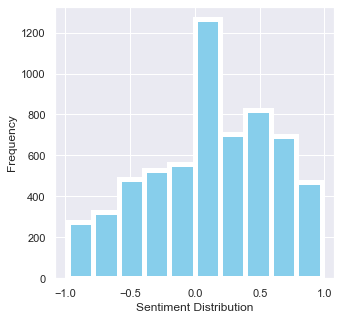

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(color_codes=True)

sns.set(rc={'figure.figsize':(5,5)})

# Create Histogram
ax = sns.distplot(tweets_df['C_Score'],
                 bins=10,
                 kde=False,
                 color='skyblue',
                 hist_kws={"linewidth":5, 'alpha':1})
ax.set(xlabel='Sentiment Distribution', ylabel='Frequency')

### Create Sentiment Column

In [33]:
# create new column
tweets_df['Sentiment'] = np.nan

# Loop through rows of dataframe and determine strings for new column "Sentiment"
for index, row in tweets_df.iterrows(): 
    if tweets_df.loc[index, 'C_Score'] > 0.05 : 
            tweets_df.loc[index, 'Sentiment'] = "Positive"       
    elif tweets_df.loc[index, 'C_Score'] < -0.05 :
            tweets_df.loc[index, 'Sentiment'] = "Negative"   
    else : 
        tweets_df.loc[index, 'Sentiment'] = "Neutral"

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [30]:
tweets_df[['stripped', 'C_Score', 'Sentiment']].head(40)

,stripped,C_Score,Sentiment
0,Every time someone writes ‘Safe’ as ‘Sfe’ I cry about how my student loan ain’t dropped yet,-0.7003,NaN
1,Zillow Moves Into Mortgage With Launch Of New Home Loan Arm http://dlvr.it/R2Bkjr,-0.2960,NaN
2,"""Factoring is like a pay day loan."" Factoring forwards you money that you are owed, not that you haven't earned yet.",-0.2023,NaN
3,"Brian Iverson a Loan Originator at Peoples Mortgage - Airpark Branch interviewing one of his referral partners. If you don't know Brian, click his name and introduce yourself or comment below to connect. :-) …",-0.1316,NaN
4,It’s NS ... taking all money of loans.\n YOITHYA,0.8834,NaN
5,"Mine too. I'm raw today tho. I tried for a VA home loan, I'm too far in debt. I'm really bummed.",0.0000,NaN
6,They can take your professional license away if you default on your student loans. How can you ever pay your debt back if they take your career away lmfaooo. What a pathetic lot of greedy morons,0.7704,NaN
7,"Dozens of banks are crossing the warning line for nonperforming loans\n\nOf the 42 banks in a Chinese province with elevated levels of nonperforming loans, a dozen reported an NPL ratio above 20%, the National Audit Office found.\n …",0.2500,NaN
8,"""Veterans United was amazing, and Sam Yoo was such a great loan officer. Thanks to them I own a home now!""\n\n: Marliez, USArmy Veteran",-0.4256,NaN
9,"I live off of a student loan, MrBeast. …",-0.6346,NaN


### More Sentiment Visualization

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 24

# Define figure
fig, ax = plt.subplots(figsize=(9, 6), subplot_kw=dict(aspect="equal"))

# Get count by sentiment category from tweets_df
sentiment_counts = tweets_df.Sentiment.value_counts()
labels = sentiment_counts.index

color_palette_list = ['lightgreen', 'orange', 'skyblue']

# Generate graph components
wedges, texts, autotexts = ax.pie(sentiment_counts, wedgeprops=dict(width=0.5), startangle=-40,
                                 colors=color_palette_list[0:3], autopct='%1.0f%%', pctdistance=.75, textprops={'color':"w", 'weight':'bold'})

# Plot wedges
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0, angleB={}".format(ang)
    ax.annotate(labels[i], xy=(x, y), xytext=(1.2*x, 1.2*y),
                horizontalalignment=horizontalalignment)

ax.set_title("Sentiment Distribution", y=.95, fontsize = 24)


plt.show()

In [ ]:
import math
tweets_df['date'] = [one.date() for one in tweets_df['timestamp']]
tweets_df = tweets_df.sort_values(by=['date'])

sentiments = ["Positive", "Neutral", "Negative"]
positiveProps = (tweets_df[tweets_df.Sentiment == 'Positive'].groupby(['date']).count()[['Sentiment']]/ tweets_df.groupby(['date']).count()[['Sentiment']])*100
neutralProps = (tweets_df[tweets_df.Sentiment == 'Neutral'].groupby(['date']).count()[['Sentiment']]/ tweets_df.groupby(['date']).count()[['Sentiment']])*100
negativeProps = (tweets_df[tweets_df.Sentiment == 'Negative'].groupby(['date']).count()[['Sentiment']]/ tweets_df.groupby(['date']).count()[['Sentiment']])*100
 
positiveProps = positiveProps['Sentiment'].tolist()
neutralProps = neutralProps['Sentiment'].tolist()
negativeProps = negativeProps['Sentiment'].tolist()
plt.figure(figsize=[16, 5])
barWidth = 0.5
labels = tweets_df.date.unique()
r = np.arange(len(labels))
positiveProps = [0 if math.isnan(x) else x for x in positiveProps]
neutralProps = [0 if math.isnan(x) else x for x in neutralProps]
negativeProps = [0 if math.isnan(x) else x for x in negativeProps]

plt.bar(r,positiveProps, color='lightgreen', edgecolor='white', width=barWidth)
plt.bar(r, neutralProps, bottom=positiveProps, color='skyblue', edgecolor='white', width=barWidth)
plt.bar(r, negativeProps, bottom=[i+j for i,j in zip(positiveProps, neutralProps)], color='orange', edgecolor='white', width=barWidth)
 
plt.xticks(r, labels, rotation = 45, fontsize=12)
plt.yticks(fontsize=16)
plt.suptitle('Sentiment Distribution over Time')
plt.xlabel("Date", fontsize=18)
plt.ylabel("Share", fontsize=20)
plt.legend(sentiments)
plt.show()

### 2019 & 2020 Word Clouds

In [34]:
#import regular expressions
import re

#Set-up patterns to be removed for the tweets
pat1 = r"https\S+"
pat2 = r"#"
pat3 = r"@"
pat4 = r"FAV"
pat5 = r"RE"
pat6 = r"pic.\S+"
combined_pat = r'|'.join((pat1, pat2, pat3, pat4, pat5, pat6))


# 2019
# replace the patterns with an empty string
tweets2019_df['stripped'] = [re.sub(combined_pat, '', w) for w in tweets2019_df.text]

#might have double spaces now (because of empty string replacements above) - remove double spaces
tweets2019_df['stripped'] = [re.sub(r"  ", ' ', w) for w in tweets2019_df.loc[:,'stripped']]

    
    
# 2020
# replace the patterns with an empty string
tweets2020_df['stripped'] = [re.sub(combined_pat, '', w) for w in tweets2020_df.text]

#might have double spaces now (because of empty string replacements above) - remove double spaces
tweets2020_df['stripped'] = [re.sub(r"  ", ' ', w) for w in tweets2020_df.loc[:,'stripped']]



In [35]:
# Import the sentiment module (if you haven't already done so)
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Import numpy (if you have not already done so)
import numpy as np

# Instantiate the sentiment analyzer (if you haven't already done so)
analyser = SentimentIntensityAnalyzer()


# 2019
# Now get the compound sentiment score for each tweet
tweets2019_df['C_Score'] = np.nan
for index, row in tweets2019_df.iterrows(): 
    tweets2019_df.loc[index, 'C_Score'] = analyser.polarity_scores(row['stripped'])['compound']
# Let's take a look!


# 2020
# Now get the compound sentiment score for each tweet
tweets2020_df['C_Score'] = np.nan
for index, row in tweets2020_df.iterrows(): 
    tweets2020_df.loc[index, 'C_Score'] = analyser.polarity_scores(row['stripped'])['compound']
# Let's take a look!

In [36]:
# 2019
tweets2019_df['Sentiment'] = np.nan

# Loop through rows of dataframe and determine strings for new columns
for index, row in tweets2019_df.iterrows():
    if tweets2019_df.loc[index, 'C_Score'] > 0.05 :
        tweets2019_df.loc[index, 'Sentiment'] = "Positive"
    elif tweets2019_df.loc[index, 'C_Score'] < -0.05 : 
        tweets2019_df.loc[index, 'Sentiment'] = "Negative"
    else :
        tweets2019_df.loc[index, 'Sentiment'] = "Neutral"
        
        
# 2020
tweets2020_df['Sentiment'] = np.nan

# Loop through rows of dataframe and determine strings for new columns
for index, row in tweets2020_df.iterrows():
    if tweets2020_df.loc[index, 'C_Score'] > 0.05 :
        tweets2020_df.loc[index, 'Sentiment'] = "Positive"
    elif tweets2020_df.loc[index, 'C_Score'] < -0.05 : 
        tweets2020_df.loc[index, 'Sentiment'] = "Negative"
    else :
        tweets2020_df.loc[index, 'Sentiment'] = "Neutral"

In [37]:
# 1. Start by importing the necessary modules
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()

# 2019 tweets
tweets2019_df["Tokens"] = [[] for _ in range(len(tweets2019_df))]
tweets2019_df["CleanTweets"] = [[] for _ in range(len(tweets2019_df))]
#tweets_df['Tokens'] = tweets_df['Tokens'].astype('object')

for index, row in tweets2019_df.iterrows(): 
    tweets2019_df.at[index, 'Tokens'] = tknzr.tokenize(row['stripped'])
    
# 2020 tweets
tweets2020_df["Tokens"] = [[] for _ in range(len(tweets2020_df))]
tweets2020_df["CleanTweets"] = [[] for _ in range(len(tweets2020_df))]

for index, row in tweets2020_df.iterrows(): 
    tweets2020_df.at[index, 'Tokens'] = tknzr.tokenize(row['stripped'])

In [39]:
# 1. Start by importing required modules
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from nltk.stem import WordNetLemmatizer

# 2. Instantiate Stemmer
ps = PorterStemmer()
le = WordNetLemmatizer()

# 2019
# 3. Now clean tweets (stripped tweets!) one by one
for index, row in tweets2019_df.iterrows(): 
    # Remove Punctuation
    words = [w for w in row['Tokens']
        if w.isalpha()]  #returns "true" if string only includes alphabetical strings
    
    # Remove Stopwords
    words = [w for w in words
       if w not in stopwords.words('english')]

    # Stem or Lemmatize tokens
    #words = [ps.stem(w) for w in words]
    words = [le.lemmatize(w) for w in words]
      
    # Write cleaned list of tokens into cell
    tweets2019_df.at[index, 'Tokens'] = words

    # Put stems back into a sentence
    sentence = " ".join(token for token in words)

     # Write cleaned sentences into cell
    tweets2019_df.at[index, 'CleanTweets'] = sentence
        
# 4. Finally, check if it worked
tweets2019_df.Tokens.head(10)


# 2020
# 3. Now clean tweets (stripped tweets!) one by one
for index, row in tweets2020_df.iterrows(): 
    # Remove Punctuation
    words = [w for w in row['Tokens']
        if w.isalpha()]  #returns "true" if string only includes alphabetical strings
    
    # Remove Stopwords
    words = [w for w in words
       if w not in stopwords.words('english')]

    # Stem or Lemmatize tokens
    #words = [ps.stem(w) for w in words]
    words = [le.lemmatize(w) for w in words]
      
    # Write cleaned list of tokens into cell
    tweets2020_df.at[index, 'Tokens'] = words

    # Put stems back into a sentence
    sentence = " ".join(token for token in words)

     # Write cleaned sentences into cell
    tweets2020_df.at[index, 'CleanTweets'] = sentence
        
# 4. Finally, check if it worked
tweets2020_df.Tokens.head(10)

0    [Just, one, big, four, cut, variable, home, loan, rate, following, RBA, emergency, cut, last, week]                                                                                                                        
1    [Do, cave, We, need, done, correctly, Tight, restriction, corporation, loan, No, cruise, line, company, registered, US, employing, majority, US, worker]                                                                   
2    [provision, bailout, fund, proposed, GOP, would, allow, Mnuchin, delay, making, public, month, name, applicable, eligible, business, States, municipality, amount, individual, loan, loan, guarantee]                      
3    [It, really, make, sense, giving, big, company, money, option, small, buisness, owner, loan, small, interest, rate]                                                                                                        
4    [How, fair, man, get, three, grand, wife, two, kid, paid, student, already, going, give, folk, 

In [40]:
!pip install wordcloud

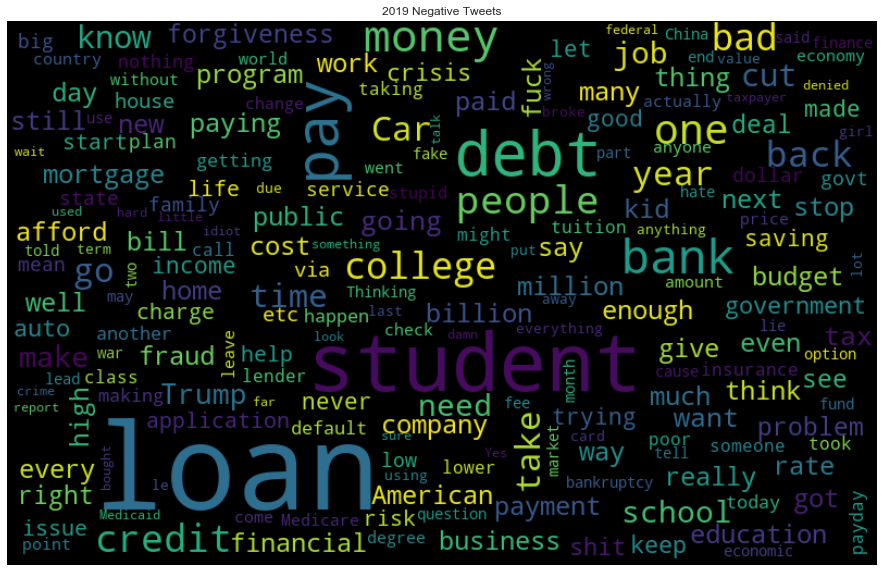

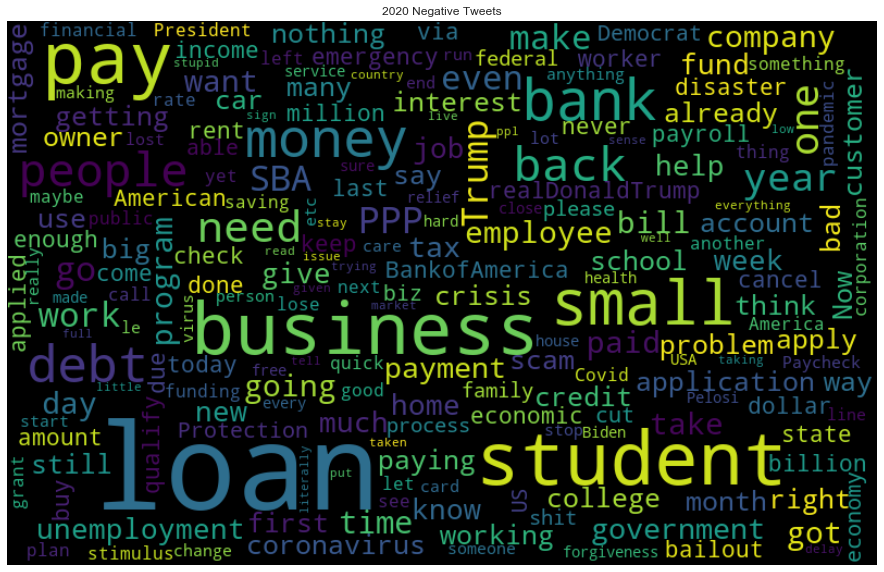

In [41]:
# Import module 
from wordcloud import WordCloud


# 2019 
all_words = ' '.join([text for text in tweets2019_df[tweets2019_df['Sentiment'] == 'Negative']['CleanTweets']])
wordcloud = WordCloud(collocations=False, width=800, height=500, random_state=5, max_font_size=110).generate(all_words)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("2019 Negative Tweets")
plt.show()

# 2020
all_words = ' '.join([text for text in tweets2020_df[tweets2020_df['Sentiment'] == 'Negative']['CleanTweets']])
wordcloud = WordCloud(collocations=False, width=800, height=500, random_state=5, max_font_size=110).generate(all_words)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("2020 Negative Tweets")
plt.show()

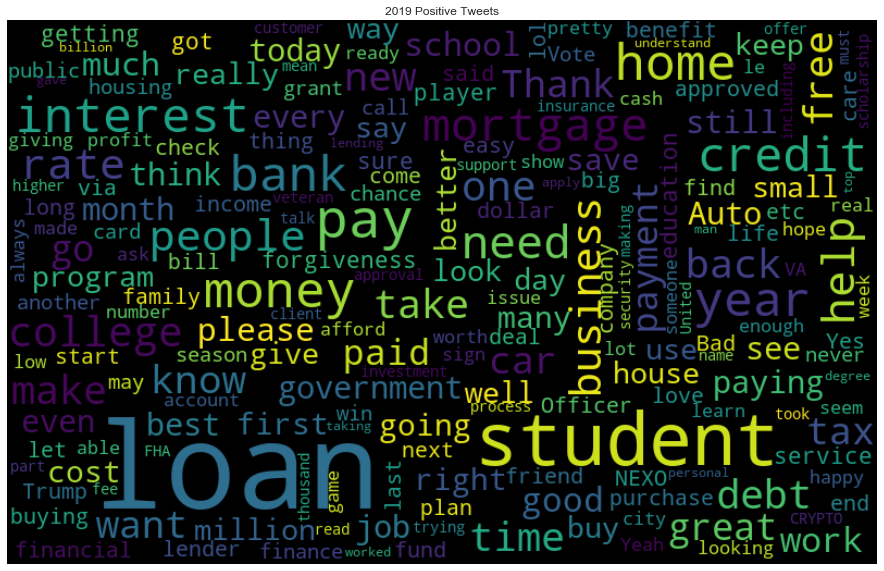

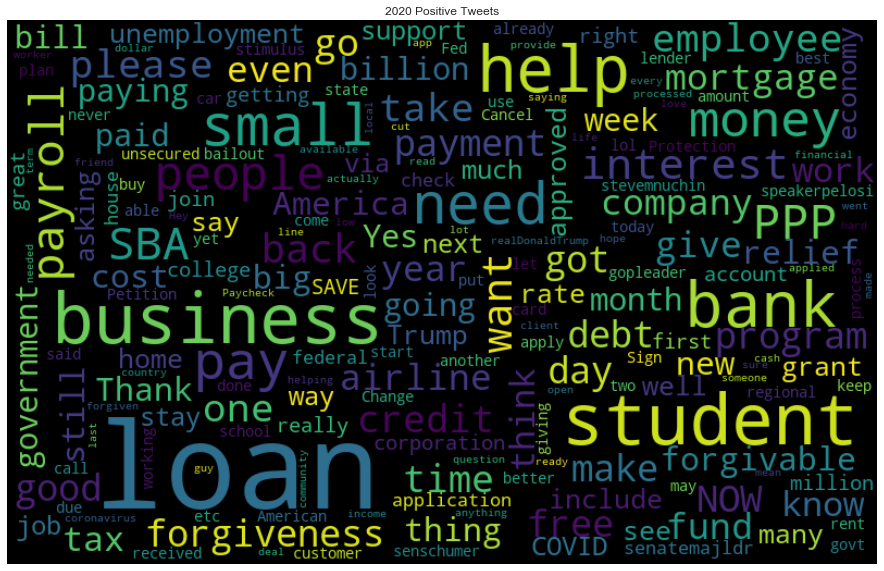

In [42]:
# Import module 
from wordcloud import WordCloud

#2019
all_words = ' '.join([text for text in tweets2019_df[tweets2019_df['Sentiment'] == 'Positive']['CleanTweets']])
wordcloud = WordCloud(collocations=False, width=800, height=500, random_state=5, max_font_size=110).generate(all_words)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("2019 Positive Tweets")
plt.show()


#2020
all_words = ' '.join([text for text in tweets2020_df[tweets2020_df['Sentiment'] == 'Positive']['CleanTweets']])
wordcloud = WordCloud(collocations=False, width=800, height=500, random_state=5, max_font_size=110).generate(all_words)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("2020 Positive Tweets")
plt.show()

### Corona Virus Sentiment Similarity

In [43]:
import numpy as np
import re

tweets2020_df['Corona'] = np.where(tweets2020_df.stripped.str.contains('(:^|\W)(covid|covid19|covid-19|corona|corona virus|coronavirus|COVID-19)', flags = re.IGNORECASE), 1, 0)

print(f"Corona {tweets2020_df['Corona'].sum()}")

Corona 142


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [44]:
print(tweets2020_df[tweets2020_df["Corona"] == 1].text.tail(25))

2320    . @dbsbank Q1 profit falls to 2.5-year low on #Covid19 loan loss provisions https://bit.ly/2yePbp1                                                                                                                                                                                                                                                                                                                                                  
2322    Small businesses move to front of coronavirus relief loan line https://mol.im/a/8270377  via http://dailym.ai/android                                                                                                                                                                                                                                                                                                                               
2335    New article: "City of Coronado Offers $2 Million in Loans to Local Businesses" has been published on F

In [45]:
import tensorflow as tf
import tensorflow_hub as hub

In [46]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" 
embed = hub.load(module_url) #download and load the model
print("Done!")

Done!


In [47]:
embeddings = embed(tweets2020_df.text)

In [48]:
import scipy.spatial

queries = ['Exactly, employment insurance. The point of the campaign is to cover students/grads who will go without employment because of covid. We’re not advocating for additional student loans.']
query_embeddings = embed(queries)

corona_idx=[]

for query, query_embedding in zip(queries, query_embeddings):
    distances = scipy.spatial.distance.cdist([query_embedding], embeddings, "cosine")[0]

    results = zip(range(len(distances)), distances)
    results = sorted(results, key=lambda x: x[1])
    
    for idx, distance in results[0:]:
        if (1-distance) > 0.4: 
            corona_idx.append(idx)

In [52]:
corona_df = pd.DataFrame([tweets2020_df.loc[i] for i in corona_idx]).reset_index(drop=True)

### Sentiment of Corona Related Tweets

In [53]:
# Import the sentiment module (if you haven't already done so)
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Import numpy (if you have not already done so)
import numpy as np

# Instantiate the sentiment analyzer (if you haven't already done so)
analyser = SentimentIntensityAnalyzer()

# Now get the compound sentiment score for each tweet
corona_df['C_Score'] = np.nan
for index, row in corona_df.iterrows(): 
    corona_df.loc[index, 'C_Score'] = analyser.polarity_scores(row['stripped'])['compound']
# Let's take a look!
pd.set_option('display.max_colwidth', -1)
corona_df[['stripped','C_Score']].head(-50)

,stripped,C_Score
0,"Exactly, employment insurance. The point of the campaign is to cover students/grads who will go without employment because of covid. We’re not advocating for additional student loans.",0.0000
1,So we should just write off a TRILLION DOLLARS in student loans with no debate? AYFKM? What about people who don’t have fancy degrees because they couldn’t afford college? Those are the people Democrat’s supposedly care about.,0.3695
2,So the relief package got blocked because the Democrats want to get rid of all of the student loans? Wtf does student loans have to do with people losing their jobs and struggling to pay bills???,-0.8394
3,This is essentially unemployment insurance for us independent contractors. I’m not completely out of work yet so I won’t qualify. I was talking about getting the SBA loan to stay afloat during this period of possible very little work.,-0.4404
4,his supporters are ALWAYS in a frenzy- it has nothing to do with anything dems do\n\ndems should state that they are NOT bailing out industries that rely on wage-slaves for profit- it's why C19 spread\nloans & grants only to those that pay living wage & paid time off to ALL WORKERS,0.6124
...,...,...
106,"“If I'm a restaurant, why would I take a loan to employ people who aren't servicing guests?” - marklevinshow (R - Not a Restaurant).\n\nBecause it’s not a “loan”, it’s a tax credit that doesn’t have to be repaid if the employees impacted by the COVIDー19 closures are retained.",0.4019
107,"Most COVID relief is 0-interest loans to ppl who need it like mom & pop retail, locally-owned restaurants, & payroll protection for min wage jobs & food insecur—HAHA JK it’s actually gifts to big banks, multinational hotel chains & tax loopholes for hedge funds. LetThemEatCake!",0.8318
108,"just got laid off until further notice, i don’t qualify for unemployment, and i have student loan bills, a car payment, rent, and i need to eat??? since i’m not at my new job at least 4 months i get no assistance this system is fucked up.",-0.8762
109,"The first mistake was underwriting the loans. But an even bigger mistake will be forgiving them. Claw it back from the university system, not the U.S. taxpayer. No more bailouts...for banks, insurance companies...or for college students. Best time in 50 years to get a job.",0.6187


In [54]:
print(f"Count positive tweets: {sum(corona_df['C_Score'] > 0.05)}")
print(f"Count netural tweets: {corona_df['C_Score'].between(-0.05, 0.05).sum()}")
print(f"Count negative tweets: {sum(corona_df['C_Score'] < -0.05)}")
print(f"Total number of tweets: {corona_df['C_Score'].count()}")
      
display(corona_df.C_Score.describe())

Count positive tweets: 68
Count netural tweets: 13
Count negative tweets: 80
Total number of tweets: 161


count    161.000000
mean    -0.026017  
std      0.512382  
min     -0.876200  
25%     -0.458800  
50%     -0.025800  
75%      0.393900  
max      0.950400  
Name: C_Score, dtype: float64

[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'Sentiment Distribution')]

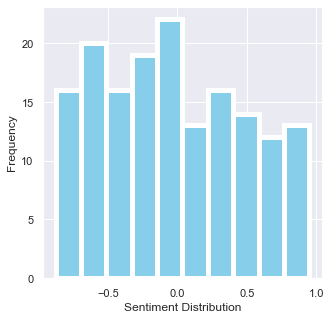

In [55]:
# import necessary modules (if not already imported)
import matplotlib.pyplot as plt
import seaborn as sns

# settings for seaborn plotting style
sns.set(color_codes=True)

# settings for seaborn plot sizes
sns.set(rc={'figure.figsize':(5,5)})

# Create Histogram
ax = sns.distplot(corona_df['C_Score'],
                  bins=10,
                  kde=False,
                  color='skyblue',
                  hist_kws={"linewidth": 5,'alpha':1})
ax.set(xlabel='Sentiment Distribution', ylabel='Frequency')

In [56]:
# create new column
corona_df['Sentiment'] = np.nan

# Loop through rows of dataframe and determine strings for new column "Sentiment"
for index, row in corona_df.iterrows(): 
    if corona_df.loc[index, 'C_Score'] > 0.05 : 
            corona_df.loc[index, 'Sentiment'] = "Positive"       
    elif corona_df.loc[index, 'C_Score'] < -0.05 :
            corona_df.loc[index, 'Sentiment'] = "Negative"   
    else : 
        corona_df.loc[index, 'Sentiment'] = "Neutral"

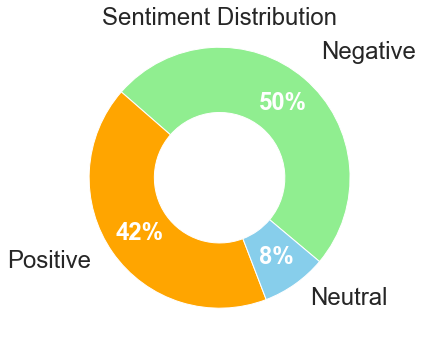

In [57]:
# import necessary modules (if not already imported)
import matplotlib.pyplot as plt

# Set font size
plt.rcParams['font.size']=24

# Define figure
fig, ax = plt.subplots(figsize=(9, 6), subplot_kw=dict(aspect="equal"))

# Get count by sentiment category from tweets_df
sentiment_counts = corona_df.Sentiment.value_counts()
labels = sentiment_counts.index

# Define colors
color_palette_list = ['lightgreen', 'orange', 'skyblue']

# Generate graph components
wedges, texts, autotexts = ax.pie(sentiment_counts, wedgeprops=dict(width=0.5), startangle=-40,  
       colors=color_palette_list[0:3], autopct='%1.0f%%', pctdistance=.75, textprops={'color':"w", 'weight':'bold'})

# Plot wedges
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    ax.annotate(labels[i], xy=(x, y), xytext=(1.2*x, 1.2*y),
                horizontalalignment=horizontalalignment)
# Set title
ax.set_title("Sentiment Distribution", y=.95, fontsize = 24)

# Show Donut Chart
plt.show()

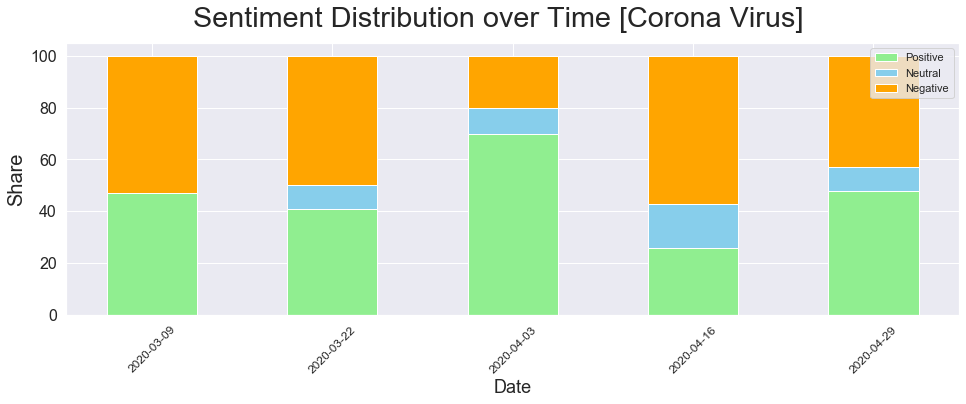

In [58]:
import math
corona_df['date'] = [one.date() for one in corona_df['timestamp']]
corona_df = corona_df.sort_values(by=['date'])

sentiments = ["Positive", "Neutral", "Negative"]
positiveProps = (corona_df[corona_df.Sentiment == 'Positive'].groupby(['date']).count()[['Sentiment']]/ corona_df.groupby(['date']).count()[['Sentiment']])*100
neutralProps = (corona_df[corona_df.Sentiment == 'Neutral'].groupby(['date']).count()[['Sentiment']]/ corona_df.groupby(['date']).count()[['Sentiment']])*100
negativeProps = (corona_df[corona_df.Sentiment == 'Negative'].groupby(['date']).count()[['Sentiment']]/ corona_df.groupby(['date']).count()[['Sentiment']])*100
 
positiveProps = positiveProps['Sentiment'].tolist()
neutralProps = neutralProps['Sentiment'].tolist()
negativeProps = negativeProps['Sentiment'].tolist()
plt.figure(figsize=[16, 5])
barWidth = 0.5
labels = corona_df.date.unique()
r = np.arange(len(labels))
positiveProps = [0 if math.isnan(x) else x for x in positiveProps]
neutralProps = [0 if math.isnan(x) else x for x in neutralProps]
negativeProps = [0 if math.isnan(x) else x for x in negativeProps]

plt.bar(r,positiveProps, color='lightgreen', edgecolor='white', width=barWidth)
plt.bar(r, neutralProps, bottom=positiveProps, color='skyblue', edgecolor='white', width=barWidth)
plt.bar(r, negativeProps, bottom=[i+j for i,j in zip(positiveProps, neutralProps)], color='orange', edgecolor='white', width=barWidth)
 
plt.xticks(r, labels, rotation = 45, fontsize=12)
plt.yticks(fontsize=16)
plt.suptitle('Sentiment Distribution over Time [Corona Virus]')
plt.xlabel("Date", fontsize=18)
plt.ylabel("Share", fontsize=20)
plt.legend(sentiments)
plt.show()

### Word Cloud for Corona Virus Loan Tweets

In [59]:
# 1. Start by importing the necessary modules
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()

# 3. Set-up two new columns: one for tokens and one for cleaned tweets
corona_df["Tokens"] = [[] for _ in range(len(corona_df))]
corona_df["CleanTweets"] = [[] for _ in range(len(corona_df))]
#tweets_df['Tokens'] = tweets_df['Tokens'].astype('object')

# 3. Now tokenize each tweet and store its tokens in a new column
for index, row in corona_df.iterrows(): 
    corona_df.at[index, 'Tokens'] = tknzr.tokenize(row['stripped']) 

In [60]:
# 1. Start by importing required modules
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from nltk.stem import WordNetLemmatizer

# 2. Instantiate Stemmer
ps = PorterStemmer()
le = WordNetLemmatizer()

# 3. Now clean tweets (stripped tweets!) one by one
for index, row in corona_df.iterrows(): 
    # Remove Punctuation
    words = [w for w in row['Tokens']
        if w.isalpha()]  #returns "true" if string only includes alphabetical strings
    
    # Remove Stopwords
    words = [w for w in words
       if w not in stopwords.words('english')]

    # Stem or Lemmatize tokens
    #words = [ps.stem(w) for w in words]
    words = [le.lemmatize(w) for w in words]
      
    # Write cleaned list of tokens into cell
    corona_df.at[index, 'Tokens'] = words

    # Put stems back into a sentence
    sentence = " ".join(token for token in words)

     # Write cleaned sentences into cell
    corona_df.at[index, 'CleanTweets'] = sentence
        
# 4. Finally, check if it worked
corona_df.Tokens.head(10)

33     [The, point, say, thousand, dollar, literally, talking, saving, millennials, enough, sad, retirement, account, literally, If, pay, student, loan, charging]                                                      
67     [I, agree, student, loan, debt, GND, So, alienate, potential, support, base, I, find, hard, argument, believe, Sanders, would, differently, table, turned]                                                       
144    [That, even, pay, year, student, loan, Not, even, month, Cheap, Tory, bastard]                                                                                                                                   
87     [time, like, plan, student, loan, Instead, throwing, every, cent, debt, held, saving, case, needed, cash, We, happened, need, reserve, anything, still, glad]                                                    
85     [answer, question, free, college, v, repaid, went, kid, school, working, field, lol, FAIR, expect, others, pay, college, loan

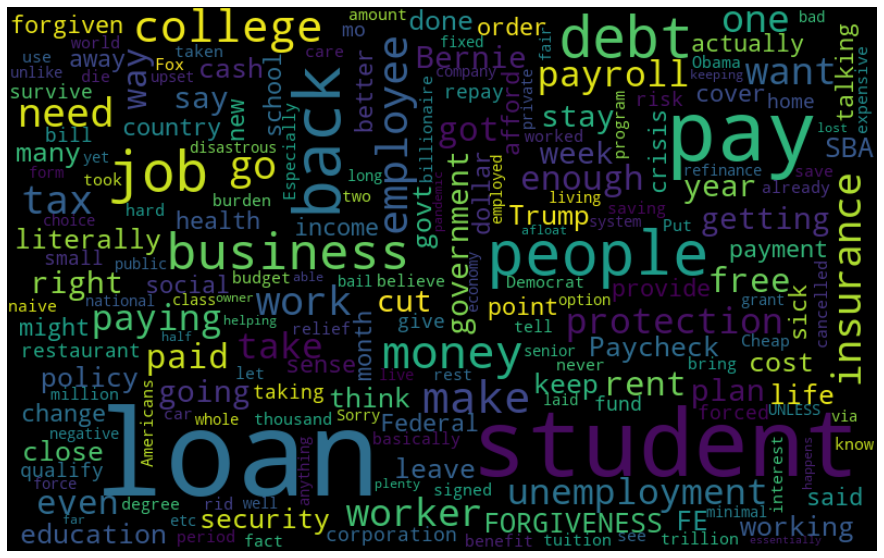

In [61]:
## Import module 
from wordcloud import WordCloud

all_words = ' '.join([text for text in corona_df[corona_df['Sentiment'] == 'Negative']['CleanTweets']])
wordcloud = WordCloud(collocations=False, width=800, height=500, random_state=5, max_font_size=110).generate(all_words)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()